<a href="https://colab.research.google.com/github/JessemanGray/Syn-Aesthetics/blob/main/Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split



In [ ]:
# Turn file path into DataFrame, show first five rows
url = ('https://raw.githubusercontent.com/JessemanGray/Syn-Aesthetics/main/ChillsDB%201.0.1%20-%20Film%20Stimuli%20(1).csv')
df = pd.read_csv(url)

df.head()

,Video ID,Age,Gender,Ethnicity,chills Binary,chills Binary.1,Chills #,Chill Intensity,Timings,Daily Chills,...,Emotion drift,Direction,Unnamed: 27,Unnamed: 28,Tan inverse,Calm Diff,Pleasure Diff,Unnamed: 32,Tan inverse.1,Unnamed: 34
0,FtCslvCjZEY,56,female,White,1,True,3,1,"53.77,85.05,450.12",3,...,0.707107,-1.557407725,NaN,NaN,-0.785398,0.5,-0.5,FALSE,-0.785398,Down
1,FtCslvCjZEY,25,male,White,1,True,1,1,401.27,1,...,0.707107,1.557407725,NaN,NaN,0.785398,-0.5,-0.5,Up,0.785398,Up
2,FtCslvCjZEY,27,male,White,1,True,6,0,"92.37,292.89,321.93,388.32,394.60,448.09",1,...,1.118034,-2.185039863,NaN,NaN,1.107149,-0.5,-1.0,Up,1.107149,Up
3,FtCslvCjZEY,39,male,White,1,True,7,3,"67.43,84.19,107.21,204.03,237.30,252.31,385.41",2,...,0.500000,#DIV/0!,NaN,NaN,-1.570000,0.0,-0.5,FALSE,-1.570000,Down
4,FtCslvCjZEY,30,male,White,1,True,2,2,"264.14,299.11",1,...,2.236068,2.185039863,NaN,NaN,-1.107149,-1.0,2.0,FALSE,-1.107149,Down


In [ ]:
# Fill missing values with the mean of the column
df = df.fillna(df.mean())

<ipython-input-3-15288beba849>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [ ]:
# Check for missing values in the entire DataFrame
missing_values = df.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

Ethnicity        1
Timings        105
Unnamed: 27    311
Unnamed: 28    311
dtype: int64


In [ ]:
# Chenck types before dropping
df['Timings'].dtypes

dtype('O')

In [ ]:
# Drop duplicate or unnecessary columns
df = df.drop(columns=['chills Binary.1', 'Unnamed: 32', 'Unnamed: 34', 'Unnamed: 28', 'Unnamed: 27', 'Timings'])


# Convert data types
df['chills Binary'] = df['chills Binary'].astype(bool)

# Check for correlation between 'Direction' and 'Tan inverse.1'
print(df[['Direction', 'Tan inverse.1']].corr())

               Tan inverse.1
Tan inverse.1            1.0


<ipython-input-6-e36ad79d19f0>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[['Direction', 'Tan inverse.1']].corr())


In [ ]:
# Show cleaned data, first five rows
df.head()

,Video ID,Age,Gender,Ethnicity,chills Binary,Chills #,Chill Intensity,Daily Chills,NIO_Openess,Prior exposure,...,Pre NEO,Post NEO,Diff NEO,Total NEO,Emotion drift,Direction,Tan inverse,Calm Diff,Pleasure Diff,Tan inverse.1
0,FtCslvCjZEY,56,female,White,True,3,1,3,3,No,...,7,11,4,18,0.707107,-1.557407725,-0.785398,0.5,-0.5,-0.785398
1,FtCslvCjZEY,25,male,White,True,1,1,1,3,Yes,...,7,11,4,18,0.707107,1.557407725,0.785398,-0.5,-0.5,0.785398
2,FtCslvCjZEY,27,male,White,True,6,0,1,3,Yes,...,7,10,3,17,1.118034,-2.185039863,1.107149,-0.5,-1.0,1.107149
3,FtCslvCjZEY,39,male,White,True,7,3,2,3,Yes,...,8,12,4,20,0.500000,#DIV/0!,-1.570000,0.0,-0.5,-1.570000
4,FtCslvCjZEY,30,male,White,True,2,2,1,3,Yes,...,8,7,-1,15,2.236068,2.185039863,-1.107149,-1.0,2.0,-1.107149


In [ ]:
def classify_chill(row):
    if row['Emotion drift'] > 0 and row['Calm Diff'] > 0 and row['Pleasure Diff'] > 0:
        return 'good'
    else:
        return 'bad'

# Apply the function to each row in your DataFrame
df['Chill Classification'] = df.apply(classify_chill, axis=1)

In [ ]:
def score(val):
    if val >= 1:
        return 3
    elif val >= 0.5:
        return 2
    elif val >= 0:
        return 1
    else:
        return 0

def classify_chill(row):
    emotion_score = score(row['Emotion drift'])
    calm_score = score(row['Calm Diff'])
    pleasure_score = score(row['Pleasure Diff'])

    # Sum the scores and normalize to a 0-10 scale
    total_score = emotion_score + calm_score + pleasure_score
    chill_rating = (total_score / 9) * 10  # 9 is the maximum total_score

    return str(round(chill_rating, 1))  # Round to 1 decimal place

df['Chill Rating'] = df.apply(classify_chill, axis=1)

In [ ]:
# prompt: df.head(

df.head(10)


,Video ID,Age,Gender,Ethnicity,chills Binary,Chills #,Chill Intensity,Daily Chills,NIO_Openess,Prior exposure,...,Total NEO,Emotion drift,Direction,Tan inverse,Calm Diff,Pleasure Diff,Tan inverse.1,Chill Classification,Chill Rating,colors
0,FtCslvCjZEY,56,female,White,True,3,1,3,3,No,...,18,0.707107,-1.557407725,-0.785398,0.5,-0.5,-0.785398,bad,4.4,#1f77b4
1,FtCslvCjZEY,25,male,White,True,1,1,1,3,Yes,...,18,0.707107,1.557407725,0.785398,-0.5,-0.5,0.785398,bad,2.2,#ff7f0e
2,FtCslvCjZEY,27,male,White,True,6,0,1,3,Yes,...,17,1.118034,-2.185039863,1.107149,-0.5,-1.0,1.107149,bad,3.3,#2ca02c
3,FtCslvCjZEY,39,male,White,True,7,3,2,3,Yes,...,20,0.500000,#DIV/0!,-1.570000,0.0,-0.5,-1.570000,bad,3.3,#d62728
4,FtCslvCjZEY,30,male,White,True,2,2,1,3,Yes,...,15,2.236068,2.185039863,-1.107149,-1.0,2.0,-1.107149,bad,6.7,#9467bd
5,FtCslvCjZEY,35,male,White,True,8,1,1,2,No,...,2,0.707107,1.557407725,0.785398,0.5,0.5,0.785398,good,6.7,#8c564b
6,FtCslvCjZEY,28,male,White,True,2,2,1,4,No,...,15,3.162278,0.3462535495,0.321751,-3.0,-1.0,0.321751,bad,3.3,#e377c2
7,FtCslvCjZEY,26,male,White,True,4,2,1,2,Yes,...,17,2.121320,-1.557407725,-0.785398,1.5,-1.5,-0.785398,bad,6.7,#7f7f7f
8,FtCslvCjZEY,23,male,Hispanic,True,2,1,1,3,No,...,12,2.915476,0.6841368083,0.540420,-2.5,-1.5,0.540420,bad,3.3,#bcbd22
9,FtCslvCjZEY,23,male,Asian,True,4,1,1,1,Yes,...,13,0.500000,0,0.000000,-0.5,0.0,0.000000,bad,3.3,#17becf


In [ ]:
# Columns with zero variance
zero_variance_columns = df.loc[:, df.nunique() == 1]
print(zero_variance_columns)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[311 rows x 0 columns]


In [ ]:
# import visualization library

from bokeh.plotting import curdoc, figure, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap

# Create a list of unique colors for each circle
colors = [Category10[10][i % 10] for i in range(len(df))]

# Add the colors to your DataFrame
df['colors'] = colors

# Create a new plot with the HoverTool
hover = HoverTool(tooltips=None, mode="vline")
p = figure(tools=[hover, 'wheel_zoom', 'pan'], title="Chill # and Chill Intensity")

# Add a circle renderer with color mapped to the new 'colors' column
p.circle('Chills #', 'Chill Intensity', radius=1, fill_color='colors', fill_alpha=0.6,
         line_color=None, source=df)

curdoc().theme = 'dark_minimal'
output_notebook()
show(p)

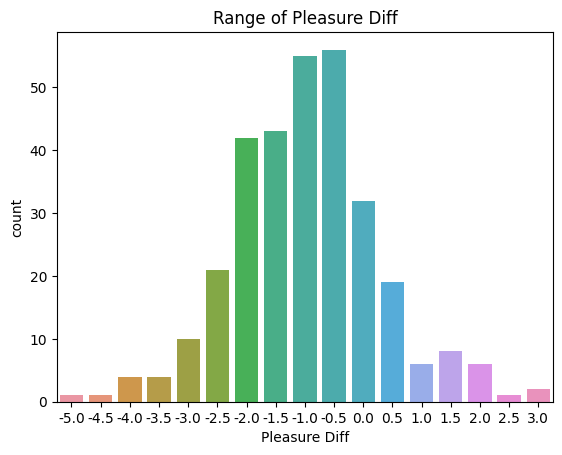

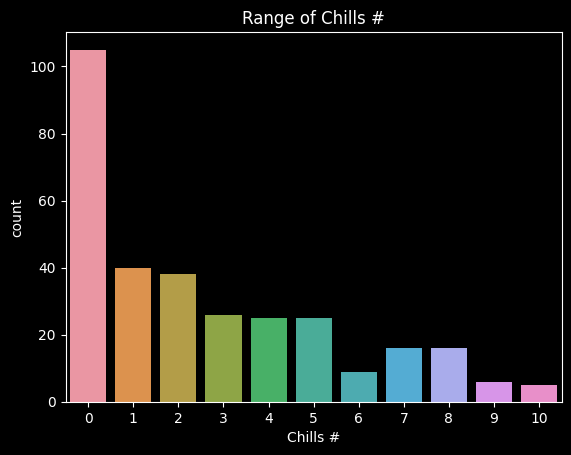

In [ ]:
# a few visualizations to explore the data
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x= 'Pleasure Diff', data=df)
plt.style.use('dark_background')
plt.title('Range of Pleasure Diff')
plt.show()

sns.countplot(x='Chills #', data=df)
plt.style.use('dark_background')
plt.title('Range of Chills #')
plt.show()


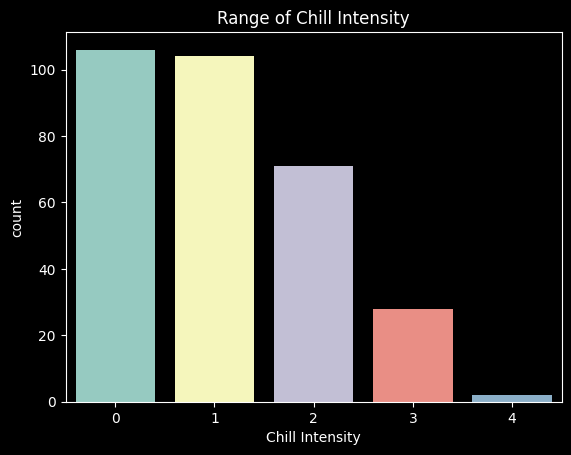

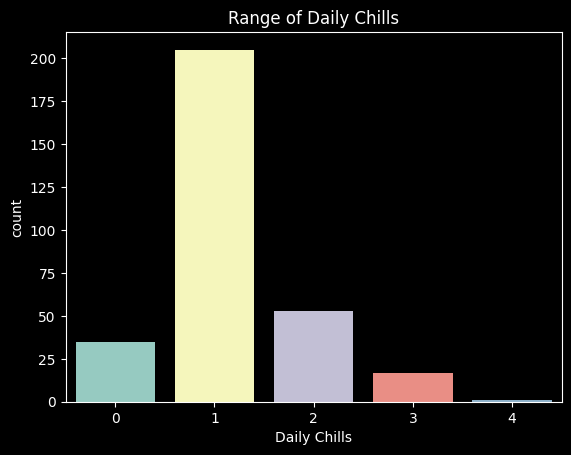

In [ ]:
# A few more
sns.countplot(x='Chill Intensity', data=df)
plt.style.use('dark_background')
plt.title('Range of Chill Intensity')
plt.show()

sns.countplot(x='Daily Chills', data=df)
plt.style.use('dark_background')
plt.title('Range of Daily Chills')
plt.show()

In [ ]:
# Calculate the correlation matrix for your selected columns
selected_columns = ['Chills #', 'Chill Intensity', 'Daily Chills', 'Pleasure Diff', 'Emotion drift', 'Direction']
corr = df[selected_columns].corr()

print(corr)

                 Chills #  Chill Intensity  Daily Chills  Pleasure Diff  \
Chills #         1.000000         0.658890      0.074208       0.139073   
Chill Intensity  0.658890         1.000000      0.194141       0.198024   
Daily Chills     0.074208         0.194141      1.000000       0.161403   
Pleasure Diff    0.139073         0.198024      0.161403       1.000000   
Emotion drift   -0.102366        -0.073111     -0.017728      -0.514638   

                 Emotion drift  
Chills #             -0.102366  
Chill Intensity      -0.073111  
Daily Chills         -0.017728  
Pleasure Diff        -0.514638  
Emotion drift         1.000000  


<ipython-input-14-b65da1d05ec6>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[selected_columns].corr()


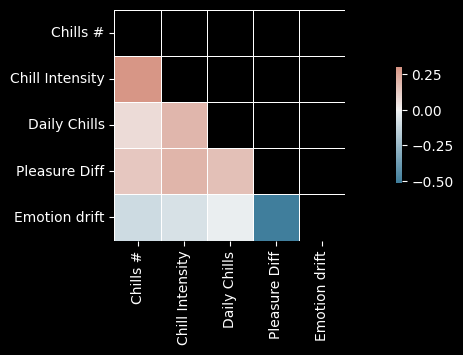

In [ ]:
# Create a grcontour graph of matrix
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [ ]:
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap

# Create a list of unique colors for each circle
colors = [Category10[10][i % 10] for i in range(len(df))]

# Add the colors to your DataFrame
df['colors'] = colors

# Create a new plot with the HoverTool
hover = HoverTool(tooltips=None, mode="vline")
p = figure(tools=[hover, 'wheel_zoom', 'pan'], title="Pleasure Diff and Chill Intensity")

# Add a circle renderer with color mapped to the new 'colors' column
p.circle('Pleasure Diff', 'Chill Intensity', radius=1, fill_color='colors', fill_alpha=0.6,
         line_color=None, source=df)

curdoc().theme = 'dark_minimal'
output_notebook()
show(p)

In [ ]:
# Assuming Pleasure Diff is binary where 1 represents good chills and 0 represents bad chills
good_chills = df[df['Pleasure Diff'] == 1]
bad_chills = df[df['Pleasure Diff'] == 0]

print("Good Chills - Mean Intensity: ", good_chills['Chill Intensity'].mean())
print("Bad Chills - Mean Intensity: ", bad_chills['Chill Intensity'].mean())


Good Chills - Mean Intensity:  1.5
Bad Chills - Mean Intensity:  1.46875


In [ ]:

print("Good Chills - Mean Intensity: ", good_chills['Chills #'].mean())
print("Bad Chills - Mean Intensity: ", bad_chills['Chills #'].mean())

Good Chills - Mean Intensity:  4.0
Bad Chills - Mean Intensity:  3.375


In [ ]:
# Assuming 'df' is your DataFrame
print("Dataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Video ID                311 non-null    object 
 1   Age                     311 non-null    int64  
 2   Gender                  311 non-null    object 
 3   Ethnicity               310 non-null    object 
 4   chills Binary           311 non-null    bool   
 5   Chills #                311 non-null    int64  
 6   Chill Intensity         311 non-null    int64  
 7   Daily Chills            311 non-null    int64  
 8   NIO_Openess             311 non-null    int64  
 9   Prior exposure          311 non-null    object 
 10  Sleppiness              311 non-null    int64  
 11  Pre-Pleasure            311 non-null    int64  
 12  Prepleasure /2 arrondi  311 non-null    int64  
 13  Prepleasure /2          311 non-null    float64
 14  Post-Pleasure           

In [ ]:
df.isnull().sum()

Video ID                  0
Age                       0
Gender                    0
Ethnicity                 1
chills Binary             0
Chills #                  0
Chill Intensity           0
Daily Chills              0
NIO_Openess               0
Prior exposure            0
Sleppiness                0
Pre-Pleasure              0
Prepleasure /2 arrondi    0
Prepleasure /2            0
Post-Pleasure             0
Pre Calm                  0
Pre-calm/2                0
Pre-calm/2 (rounded)      0
Post Calm                 0
Pre NEO                   0
Post NEO                  0
Diff NEO                  0
Total NEO                 0
Emotion drift             0
Direction                 0
Tan inverse               0
Calm Diff                 0
Pleasure Diff             0
Tan inverse.1             0
Chill Classification      0
Chill Rating              0
colors                    0
dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create your features matrix (X) by dropping all target variables at once
X = df.drop('Pleasure Diff', axis=1)

# Create your labels matrix (y) by selecting all target variables
y = df['Pleasure Diff']
# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder and transform the categorical data
X_categorical = encoder.fit_transform(X.select_dtypes(include=['object'])).toarray()

# Combine the categorical and numerical data
X_numerical = X.select_dtypes(include=['int64', 'float64']).values
X_preprocessed = np.concatenate([X_numerical, X_categorical], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

# Split the preprocessed data into training and testing sets
X_train_pre, X_test_pre, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42, shuffle=True)

# Train a stochastic gradient descent model
model = SGDRegressor()

# Fit the model to your preprocessed training data
model.fit(X_train_pre, y_train)

# Predict the target for the preprocessed testing set
y_pred = model.predict(X_test_pre)
print(y_test)
print(y_pred)

290   -1.5
9      0.0
57    -1.5
60    -2.0
25     0.5
      ... 
195   -1.5
210   -0.5
224   -0.5
158   -1.0
126   -2.0
Name: Pleasure Diff, Length: 63, dtype: float64
[9.02217515e+11 3.52928242e+11 6.66648858e+11 6.60060615e+11
 4.53106550e+11 5.95381248e+11 4.80040298e+11 5.99783351e+11
 7.74396407e+11 4.90254028e+11 5.95163180e+11 7.57376296e+11
 9.59359597e+11 2.85584965e+11 7.47036836e+11 9.97408953e+11
 5.38322314e+11 4.77758718e+11 6.75336882e+11 4.14507377e+11
 4.15227830e+11 4.70535773e+11 7.13480006e+11 6.91967873e+11
 5.36642062e+11 3.43973966e+11 7.30749770e+11 9.50195604e+11
 3.79488001e+11 7.13945198e+11 4.15965187e+11 5.78977865e+11
 4.39294220e+11 3.12814371e+11 4.54547215e+11 8.46758923e+11
 5.91235441e+11 7.66692838e+11 6.20418940e+11 7.31547202e+11
 5.66882907e+11 3.56549041e+11 6.05325937e+11 3.82939035e+11
 8.25994815e+11 8.63666044e+11 4.91959858e+11 5.89557969e+11
 9.74810570e+11 4.46179403e+11 4.63404676e+11 3.97153607e+11
 8.47165920e+11 6.25289489e+11 4.73382

In [ ]:
print(y.describe())

count    311.000000
mean      -0.982315
std        1.257433
min       -5.000000
25%       -2.000000
50%       -1.000000
75%       -0.500000
max        3.000000
Name: Pleasure Diff, dtype: float64


In [ ]:
# Extract the 'Pleasure Diff' values from y_test
y_test_values = y_test.values

print(y_test_values)

[-1.5  0.  -1.5 -2.   0.5 -2.  -1.  -1.   0.5 -1.5 -2.  -3.  -0.5 -2.5
 -2.  -1.   0.5 -0.5 -2.   0.  -1.5  0.  -0.5 -1.5 -2.  -1.  -2.  -0.5
 -0.5 -1.5  0.  -0.5 -2.5  1.5  0.  -2.5 -1.5 -0.5 -1.5 -0.5 -0.5 -1.
  0.  -1.   0.5 -1.  -4.  -1.5 -2.  -2.5 -0.5  2.  -3.   0.5  3.  -1.5
  0.5 -4.  -1.5 -0.5 -0.5 -1.  -2. ]


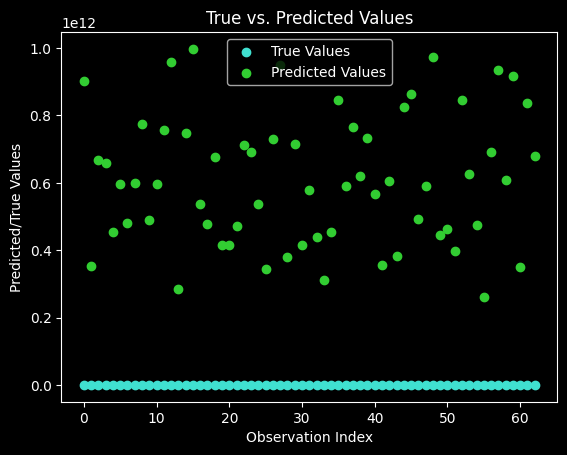

In [ ]:
import matplotlib.pyplot as plt

# Create an array for the sample number or index
index = np.arange(len(y_test_values))

# Scatter plot of the true values
plt.scatter(index, y_test_values, color='turquoise', label='True Values')

# Scatter plot of the predicted values
plt.scatter(index, y_pred, color='limegreen', label='Predicted Values')

plt.xlabel('Observation Index')
plt.ylabel('Predicted/True Values')

plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

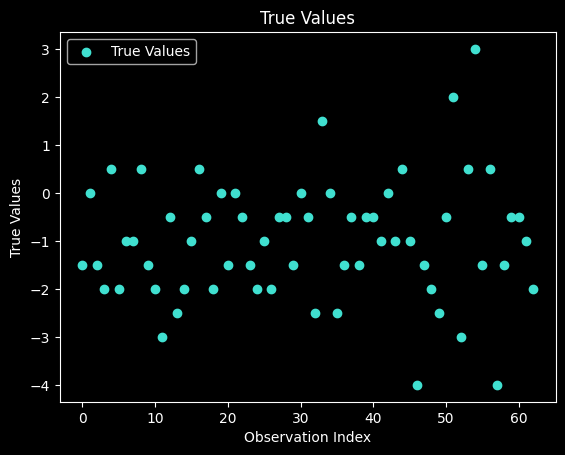

In [ ]:
plt.scatter(index, y_test_values, color='turquoise', label='True Values')
plt.xlabel('Observation Index')
plt.ylabel('True Values')
plt.title('True Values')
plt.legend()
plt.show()

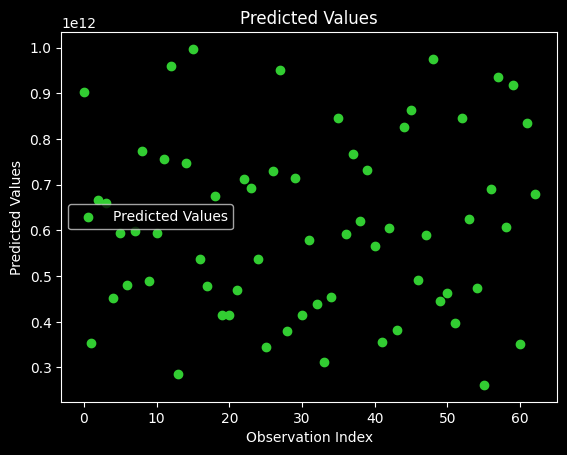

In [ ]:
plt.scatter(index, y_pred, color='limegreen', label='Predicted Values')
plt.xlabel('Observation Index')
plt.ylabel('Predicted Values')
plt.title('Predicted Values')
plt.legend()
plt.show()

In [ ]:
print(y_train.values)

[-0.5 -2.  -2.  -2.  -1.5 -1.   1.5 -3.  -1.  -0.5  2.5 -1.  -3.  -2.5
 -1.5 -2.  -2.  -0.5 -0.5 -4.5 -0.5 -2.   0.   0.  -2.5  3.   0.  -0.5
 -1.5 -0.5  0.  -1.5 -1.5 -2.5  0.  -3.5 -0.5 -2.   1.  -1.  -1.   1.5
  1.  -1.  -1.   2.  -2.  -0.5 -0.5 -2.   0.5 -2.  -1.  -1.  -1.5 -0.5
 -1.   0.5 -1.  -1.5 -2.  -1.  -3.  -2.  -1.   1.  -2.   2.  -3.  -0.5
 -2.5  0.  -1.   1.5 -2.5 -1.5 -1.5 -1.5  0.   1.  -1.  -1.   2.  -1.
 -2.   0.  -1.  -2.5 -3.5 -1.5 -1.  -0.5 -0.5 -1.  -1.5 -1.  -0.5 -2.
 -2.  -2.  -4.  -0.5 -0.5 -1.5 -1.   0.   0.5 -2.   0.5 -0.5  0.   2.
 -0.5 -0.5  0.  -2.5 -1.   0.  -2.5 -1.5 -1.  -2.  -3.5 -1.5  0.  -0.5
  0.5 -0.5 -2.5 -1.  -0.5 -2.5 -2.  -1.5 -1.   0.   1.  -1.  -1.   0.
  1.  -0.5 -0.5 -0.5 -1.  -0.5 -1.  -1.   2.  -1.5  0.  -1.  -2.  -2.
  0.  -0.5 -1.   0.5 -0.5 -2.5 -1.5 -1.5  0.   1.5  1.5 -1.  -0.5 -2.
 -2.  -3.  -1.  -2.5 -1.  -0.5 -3.   0.5 -1.5 -0.5  0.5 -2.   0.5 -1.
 -2.  -1.  -0.5  0.   0.5 -1.  -1.5  0.5 -2.5  0.  -2.  -2.5 -3.  -2.
 -1.  -1.5  1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns
df_selected = df[['Pleasure Diff']]

# Fill any missing values
df_selected.fillna(method='ffill', inplace=True)

# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_selected)

# Convert the DataFrame to a 3D array for LSTM
# The shape should be (number of samples, 1, number of features)
df_reshaped = np.reshape(df_scaled, (df_scaled.shape[0], 1, df_scaled.shape[1]))

<ipython-input-29-6548cf1f7f5a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(method='ffill', inplace=True)


In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(df_reshaped.shape[1], df_reshaped.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam', metrics='accuracy')

# Train the model
history = model.fit(df_reshaped, df['Pleasure Diff'], epochs=50, batch_size=72, validation_split=0.2, verbose=0, shuffle=False)

10/10 [==============================] - 1s 3ms/step


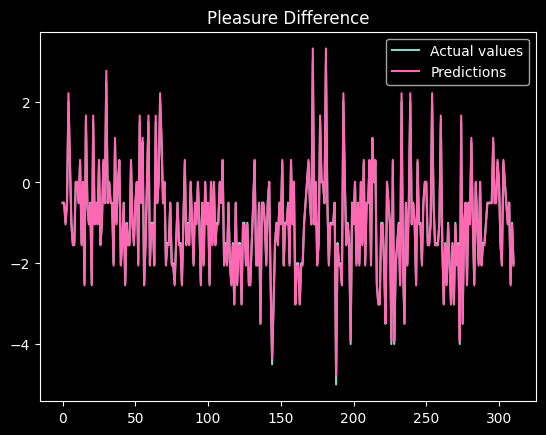

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler for the target variable
scaler_target = MinMaxScaler(feature_range=(0, 1))
df_target_scaled = scaler_target.fit_transform(df[['Pleasure Diff']])

# Train the model
history = model.fit(df_reshaped, df_target_scaled, epochs=50, batch_size=72, validation_split=0.2, verbose=0, shuffle=False)

# Make predictions
predictions = model.predict(df_reshaped)

# Invert scaling for the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Plot the actual values vs the predictions
plt.plot(df['Pleasure Diff'].values, label='Actual values')
plt.plot(predictions_rescaled, label='Predictions',color='hotpink')
plt.title('Pleasure Difference')
plt.legend()
plt.show()

<ipython-input-33-febc3ff5fe1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(method='ffill', inplace=True)


10/10 [==============================] - 1s 3ms/step


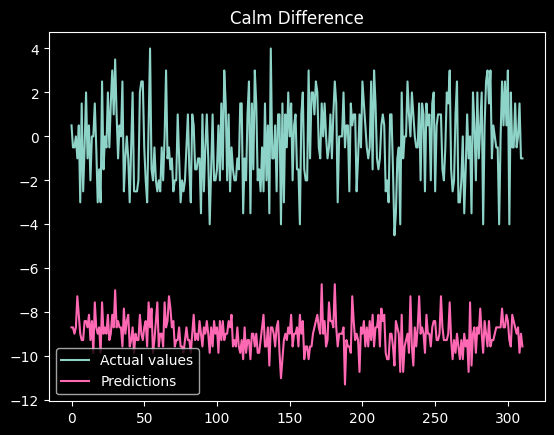

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns
df_selected = df[['Pleasure Diff']]

# Fill any missing values
df_selected.fillna(method='ffill', inplace=True)

# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_selected)

# Convert the DataFrame to a 3D array for LSTM
# The shape should be (number of samples, 1, number of features)
df_reshaped = np.reshape(df_scaled, (df_scaled.shape[0], 1, df_scaled.shape[1]))


from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(df_reshaped.shape[1], df_reshaped.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam', metrics='accuracy')

# Train the model
history = model.fit(df_reshaped, df['Calm Diff'], epochs=50, batch_size=72, validation_split=0.2, verbose=0, shuffle=False)

# Make predictions
predictions = model.predict(df_reshaped)

# Invert scaling for the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Plot the actual values vs the predictions
plt.plot(df['Calm Diff'].values, label='Actual values')
plt.plot(predictions_rescaled, label='Predictions',color='hotpink')
plt.title('Calm Difference')
plt.legend()
plt.show()

<ipython-input-37-a41558532e7d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(method='ffill', inplace=True)


10/10 [==============================] - 1s 3ms/step


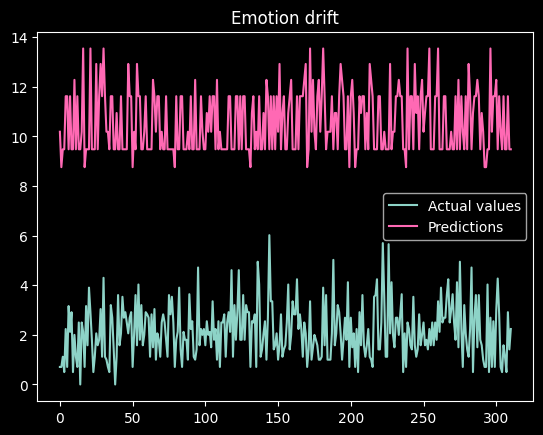

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant columns
df_selected = df[['Chill Rating']]

# Fill any missing values
df_selected.fillna(method='ffill', inplace=True)

# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_selected)

# Convert the DataFrame to a 3D array for LSTM
# The shape should be (number of samples, 1, number of features)
df_reshaped = np.reshape(df_scaled, (df_scaled.shape[0], 1, df_scaled.shape[1]))


from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(df_reshaped.shape[1], df_reshaped.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mae', optimizer='adam', metrics='accuracy')

# Train the model
history = model.fit(df_reshaped, df['Emotion drift'], epochs=50, batch_size=72, validation_split=0.2, verbose=0, shuffle=False)

# Make predictions
predictions = model.predict(df_reshaped)

# Invert scaling for the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Plot the actual values vs the predictions
plt.plot(df['Emotion drift'].values, label='Actual values')
plt.plot(predictions_rescaled, label='Predictions',color='hotpink')
plt.title('Emotion drift')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stocha

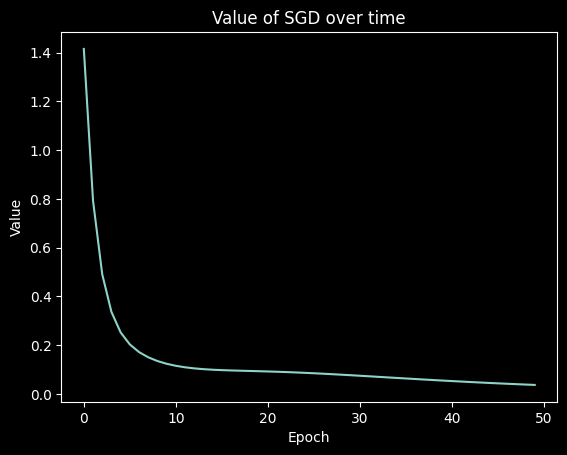

In [ ]:
# Create a SGDRegressor object
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

# Prepare to store the cost at each iteration
costs = []
n_epochs = 50

# Fit the model for n_epochs epochs
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_pre, y_train.values.ravel())
    y_pred = sgd_reg.predict(X_train_pre)
    cost = np.mean((y_pred - y_train.values.ravel())**2)
    costs.append(cost)

# Plot the cost over time
plt.plot(range(n_epochs), costs)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Value of SGD over time')
plt.show()